In [1]:
import sys
import os
sys.path.append('/home/franzi/anzeigendaten/python_base/skillextraktion/fh_ma')
sys.path.append('/home/franzi/anzeigendaten/EnvPython')
import prepare_training_data
from labels import *
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.utils import shuffle

start = time.time()
x_train, y_train, x_test, y_test, test_afks, features = prepare_training_data.get_training_data()
print('took: ',time.time()-start)

20861874
0
skipgram, punctuation_marks, stoppwords, multiword, lower_case, vector_dim True False False False False 100
init /home/franzi/Documents/models/no_pm_no_sw_vecDim100/skip_gram_model.model
loading existing w2v model from  /home/franzi/Documents/models/no_pm_no_sw_vecDim100/skip_gram_model.model
using data from  /home/franzi/Documents/data/data_4_vecDim100
loading data...
37823 37823 12053 12053 0 0
took:  4.53870701789856


In [ ]:
import numpy as np
label_y = prepare_training_data.one_hot_to_labels(y_train)

In [4]:
from tensorflow.keras import *

In [5]:
x_train = x_train.reshape([x_train.shape[0],-1, x_train.shape[1], x_train.shape[2],1])
x_test = x_test.reshape([x_test.shape[0],-1,  x_test.shape[1], x_test.shape[2],1])

In [6]:
print(x_train.shape)
print(x_test.shape)
# Build the model
print('Build model...')
model = Sequential()
model.add(layers.ConvLSTM2D(filters=64, kernel_size=(3,3), padding='same', return_sequences=True, input_shape=(None,x_train.shape[2],x_train.shape[3], 1)))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.ConvLSTM2D(filters=128, kernel_size=(3,3), padding='same', return_sequences=True, kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.ConvLSTM2D(filters=128, kernel_size=(3,3), padding='same', return_sequences=True, kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.ConvLSTM2D(filters=64, kernel_size=(3,3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(64))
model.add(layers.Dense(64))
model.add(layers.Dense(units=len(labels)))
model.add(layers.Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

model.evaluate(x=x_test, y=y_test)

batch_size=32
history = model.fit(x_train, y_train, batch_size=batch_size, shuffle=True, epochs=3, validation_data=(x_test, y_test))

2020-08-10 16:32:37 WARNING: From /home/franzi/.local/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


(37823, 1, 9, 100, 1)
(12053, 1, 9, 100, 1)
Build model...
12053/12053 [==============================] - 350s 29ms/sample - loss: 6.9761 - acc: 0.0192
Train on 37823 samples, validate on 12053 samples


2020-08-10 16:38:32 WARNING: From /home/franzi/.local/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/3
37823/37823 [==============================] - 4714s 125ms/sample - loss: 1.6349 - acc: 0.7530 - val_loss: 0.9906 - val_acc: 0.7854
Epoch 2/3
37823/37823 [==============================] - 4778s 126ms/sample - loss: 1.0087 - acc: 0.7860 - val_loss: 0.9958 - val_acc: 0.7900
Epoch 3/3
37823/37823 [==============================] - 4749s 126ms/sample - loss: 0.9794 - acc: 0.7966 - val_loss: 1.0445 - val_acc: 0.7771


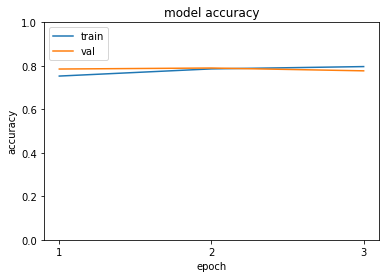

In [7]:
from matplotlib import pyplot as plt
plt.plot(np.arange(1, len(history.history['acc'])+1), history.history['acc'])
plt.plot(np.arange(1, len(history.history['acc'])+1), history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(0,1)
plt.xticks(np.arange(1, len(history.history['acc'])+1))
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [12]:
# predict test data
y_pred = model.predict(x_test)

In [ ]:
import numpy as np
# convert one hot to labels for test data
pred_label = prepare_training_data.one_hot_to_labels(y_pred)
true_label = prepare_training_data.one_hot_to_labels(y_test)

In [14]:
# Calc metrics for test data
import sklearn
from sklearn.metrics import precision_score, recall_score
from tabulate import tabulate
label_list = list(labels.keys())

headers = [l for l in label_list ]
headers = [' '] + headers

table=[['precision'] + list(precision_score(true_label, pred_label, average=None)), 
       ['recall']+list(recall_score(true_label, pred_label, average=None)), 
       ['f1']+ list(sklearn.metrics.f1_score(true_label, pred_label, average=None))]

print(tabulate(table, headers=headers, tablefmt='orgtbl'))
f1 = sklearn.metrics.f1_score(true_label, pred_label, average=None)
f1 = np.delete(f1, 4)
f1 = np.delete(f1, 6)
print('f1 average: ',sum(sklearn.metrics.f1_score(true_label, pred_label, average=None))/len(list(precision_score(true_label, pred_label, average=None))))
print('f1 average: ',sum(f1)/6)
print('Precision average: ',sum(precision_score(true_label, pred_label, average=None)/8))
print('recall average: ',sum(recall_score(true_label, pred_label, average=None)/8))
print('acc', sklearn.metrics.accuracy_score(true_label, pred_label))

|           |   Ausbildung |     Beruf |   allgemein |   berufsspez |   Sprache |   Technologie |   Softskill |   noSkill |
|-----------+--------------+-----------+-------------+--------------+-----------+---------------+-------------+-----------|
| precision |     0.550773 | 0.166667  |   0.445652  |     0.505678 |  0.676471 |      0.785714 |    0.660514 |  0.88183  |
| recall    |     0.903986 | 0.0625    |   0.0575035 |     0.624299 |  0.936652 |      0.738065 |    0.76416  |  0.864266 |
| f1        |     0.684499 | 0.0909091 |   0.101863  |     0.558762 |  0.785579 |      0.761144 |    0.708567 |  0.87296  |
f1 average:  0.570535405894382
f1 average:  0.4842907783447625
Precision average:  0.584162239922572
recall average:  0.6189287262092428
acc 0.7770679498879947


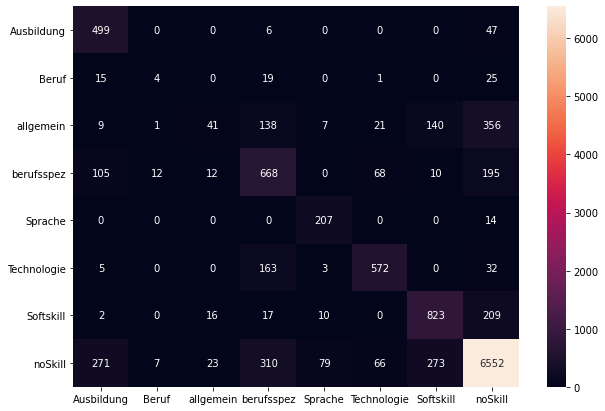

In [15]:
# Create Confusion Matrix

import sklearn
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

cm = sklearn.metrics.confusion_matrix(true_label, pred_label)
df_cm = pd.DataFrame(cm, labels,columns = labels)
plt.figure(figsize = (10,7))
plt.ylabel('Eingabe')
plt.xlabel('Ausgabe')
sn.heatmap(df_cm, annot=True,fmt='g')

In [16]:
# clean noSkill for evaluation
clean_y_pred = []
clean_y_test = []
true_noSkills = 0
clean_x_test = []
afks = []

for i in range(len(y_test)):
    if(true_label[i] != 7 or pred_label[i] != 7):
        clean_x_test.append(x_test[i])
        clean_y_pred.append(pred_label[i])
        clean_y_test.append(true_label[i])
        afks.append(test_afks[i])
    else:
        true_noSkills += 1
pred_label = clean_y_pred
true_label = clean_y_test
print('correctly labeled noSkills: ', true_noSkills)

correctly labeled noSkills:  6552


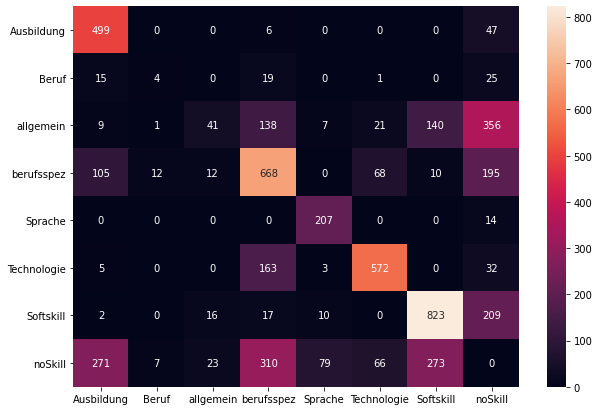

In [17]:
# Create Confusion Matrix

import sklearn
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

cm = sklearn.metrics.confusion_matrix(true_label, pred_label)
df_cm = pd.DataFrame(cm, labels,columns = labels)
plt.figure(figsize = (10,7))
plt.ylabel('Eingabe')
plt.xlabel('Ausgabe')
sn.heatmap(df_cm, annot=True,fmt='g')